In [18]:
import h5py
import numpy as np
from skimage.util.shape import view_as_windows
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import pandas

In [2]:
def def_cmap(color):
    colors = ["white", color]
    n_bins = 100
    cmap_name = "cmap"
    self_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    return self_cmap

In [3]:
with h5py.File("averaging_test/U_avg.h5", "r") as file:
    U = file["matrix"][:]

with h5py.File("averaging_test/V_avg.h5", "r") as file:
    V = file["matrix"][:]

with h5py.File("averaging_test/M_avg.h5", "r") as file:
    M = file["matrix"][:]
    
with h5py.File("averaging_test/xgrid_matrix", "r") as file:
    xgrid = file["matrix"][:]
    
with h5py.File("averaging_test/ygrid_matrix", "r") as file:
    ygrid = file["matrix"][:]

# Replace nan in U and V into zeros.
U = np.nan_to_num(U) # (#step, 63, 53) dimensional numpy array.
V = np.nan_to_num(V)

In [4]:
def decode(elem):
    return elem.decode("UTF-8")

with h5py.File("start_points.h5", "r") as file:
    track_id = (list(map(decode, file["track_id"][:])))
    start_x_cor = file["start_x"][:] # List of 1 element lists
    start_y_cor = file["start_y"][:] # List of 1 element lists
    start_t = file["t_interval"][:]  # List of 2 element lists

In [5]:
def get_window_avg(ar, W, i, j):
    # For a given 2D numpy array "ar" extract at the index i,j the subarray with size W = (a, b).
    # Finally return the mean value of the window. 
    # Out of boundary regions are filled by 0.
    h0,h1 = (W[0]-1)//2, (W[1]-1)//2 
    ar_ext = np.pad(ar,((h0,h0),(h1,h1)),'constant',constant_values=(0,0))
    window = view_as_windows(ar_ext, (W[0],W[1]))[i,j]
    return np.mean(window)

In [6]:
def pseudo_tracking_piv_grid_single(U, V, t_interval, start_x, start_y, scale=(1, 1)):
    # U, V: (#total_time, 63, 63) dimensional
    # t_interval: [t0, t1] two element list
    # start_x: [x0] one element list. x, y in vector field grid.
    # start_y: [y0] one element list
    
    # start_x and start_y integers inside x and y dimensions.
    # Firstly using the coordinate of vector field. 
    x_dim = np.shape(U)[1]
    y_dim = np.shape(U)[2]

    t_interval = range(t_interval[0], t_interval[1]+1)
    num_step = len(t_interval)
    
    trajectory_x = [start_x[0]]
    trajectory_y = [start_y[0]]

    for i in range(1,num_step):
        
        x_cor = trajectory_x[i-1]
        y_cor = trajectory_y[i-1]
        t = t_interval[i]

        # Determine the vector directions through averaging surrounding neighbours.
        dx = scale[0] * get_window_avg(U[t-1], (3, 3), x_cor, y_cor) # Indexing in python begins with 0. 
        #dx = scale[0] * U[t-1][x_cor, y_cor]
        dy = scale[1] * get_window_avg(V[t-1], (3, 3), x_cor, y_cor)
        #dy = scale[1] * V[t-1][x_cor, y_cor]

        # Update of the start positions and round to the nearest integer.
        update_x_cor = round(x_cor + dx)
        update_y_cor = round(y_cor + dy)

        # Stays in the same position if comes to the image boundary. # TODO: Reweite it in a better way! 
        if update_x_cor < 0 or update_x_cor >= x_dim:
            trajectory_x.append(trajectory_x[i-1])
            trajectory_y.append(trajectory_y[i-1])
            continue
        elif update_y_cor < 0 or update_y_cor >= y_dim:
            trajectory_x.append(trajectory_x[i-1])
            trajectory_y.append(trajectory_y[i-1])
            continue
            
        trajectory_x.append(update_x_cor)
        trajectory_y.append(update_y_cor)

    return np.array(trajectory_x), np.array(trajectory_y)

In [7]:
def pseudo_tracking_piv_grid(U, V, t_interval_array, start_x_array, start_y_array, scale=(1, 1)):
    # t_interval_array: [[t0, t1], ...] list of two element lists
    # start_x_array: [[x0], ...] list of one element lists, image coordinates.
    # start_y_array: [[y0], ...] list of one element lists, image coordinates.
    all_x_trajectory = []
    all_y_trajectory = []

    for i in range(len(start_x_array)):
        # Transform the x and y in image coordinates into vector field grid.
        start_x = [round(start_x_array[i][0]/16) - 1]
        start_y = [round(start_y_array[i][0]/16) - 1]
        t_interval = t_interval_array[i]

        x_track, y_track = pseudo_tracking_piv_grid_single(U, V, t_interval, start_x, start_y, scale)
        # Get the track results in vector field grid and transform into image coordinate.
        all_x_trajectory.append((x_track+1) * 16)
        all_y_trajectory.append((y_track+1) * 16)

    return all_x_trajectory, all_y_trajectory

In [88]:
def pseudo_tracking_piv_grid_single_v2(U, V, t_interval, start_x, start_y, scale=(1, 1)):
    # U, V: (#total_time, 63, 63) dimensional
    # t_interval: [t0, t1] two element list
    # start_x: [x0] one element list. x, y in image coordinate.
    # start_y: [y0] one element list
    
    # start_x and start_y integers inside x and y dimensions.
    # Firstly using the coordinate of vector field. 
    x_dim = np.shape(U)[1]
    y_dim = np.shape(U)[2]

    t_interval = range(t_interval[0], t_interval[1]+1)
    num_step = len(t_interval)
    
    trajectory_x = [start_x[0]] # starting points in image coordinates.
    trajectory_y = [start_y[0]]

    for i in range(1,num_step):
        # Transform the points into vector field grid. 
        x_cor = round(trajectory_x[i-1]/16 - 1)
        y_cor = round(trajectory_y[i-1]/16 - 1)
        t = t_interval[i]

        # Determine the vector directions through averaging surrounding neighbours.
        dx = scale[0] * get_window_avg(U[t-1], (3, 3), x_cor, y_cor) # Indexing in python begins with 0. 
        dy = scale[1] * get_window_avg(V[t-1], (3, 3), x_cor, y_cor)

        # Update of the start positions in image coordinate and round to the nearest integer.
        update_x_cor = round(x_cor + dx)
        update_y_cor = round(y_cor + dy)

        # Stays in the last inside position if comes over the image boundary. # TODO: Reweite it in a better way! 
        if update_x_cor < 0 or update_x_cor >= x_dim:
            trajectory_x.append(trajectory_x[i-1])
            trajectory_y.append(trajectory_y[i-1])
            continue
        elif update_y_cor < 0 or update_y_cor >= y_dim:
            trajectory_x.append(trajectory_x[i-1])
            trajectory_y.append(trajectory_y[i-1])
            continue

        final_update_x = round((x_cor + dx + 1) * 16) # Final results in image coordinate.
        final_update_y = round((y_cor + dy + 1) * 16)

        trajectory_x.append(final_update_x)
        trajectory_y.append(final_update_y)

    return np.array(trajectory_x), np.array(trajectory_y) # Final results in image coordinate.

In [92]:
def pseudo_tracking_piv_grid_v2(U, V, t_interval_array, start_x_array, start_y_array, scale=(1, 1)):
    # t_interval_array: [[t0, t1], ...] list of two element lists
    # start_x_array: [[x0], ...] list of one element lists, image coordinates.
    # start_y_array: [[y0], ...] list of one element lists, image coordinates.
    all_x_trajectory = []
    all_y_trajectory = []

    for i in range(len(start_x_array)):
        # Transform the x and y in image coordinates into vector field grid.
        start_x = start_x_array[i]
        start_y = start_y_array[i]
        t_interval = t_interval_array[i]

        x_track, y_track = pseudo_tracking_piv_grid_single_v2(U, V, t_interval, start_x, start_y, scale)
        # Get the track results in vector field grid and transform into image coordinate.
        all_x_trajectory.append(x_track)
        all_y_trajectory.append(y_track)

    return all_x_trajectory, all_y_trajectory


In [8]:
# Plot the pseudo track results
def plot_pseudo_track(track_id, x_track, y_track, t_track, fig_size):
    plt.style.use('dark_background')
    colors = list(mcolors.CSS4_COLORS.keys())
    
    plt.figure(figsize=(10, 10))
    for i in range(len(track_id)):
        
        x_cor = x_track[i]
        y_cor = y_track[i]
        t_interval = range(t_track[i][0], t_track[i][-1]+1)
        
        plt.plot(x_cor, y_cor, color=colors[i], zorder=1)
        cmap = def_cmap(colors[i])
        plt.scatter(x_cor, y_cor, c=t_interval, zorder=2, cmap=cmap)
        plt.annotate(str(track_id[i]), xy = (x_cor[0], y_cor[0]), c=colors[i])
    
    plt.xlim(0, fig_size)
    plt.ylim(0, fig_size)
    plt.gca().invert_yaxis()
    #plt.savefig("pseudotrack_vector_field_cor", dpi=300)
    plt.show()

In [85]:
all_x_track, all_y_track = pseudo_tracking_piv_grid(U, V, start_t, start_x_cor, start_y_cor, (0.8, 1))

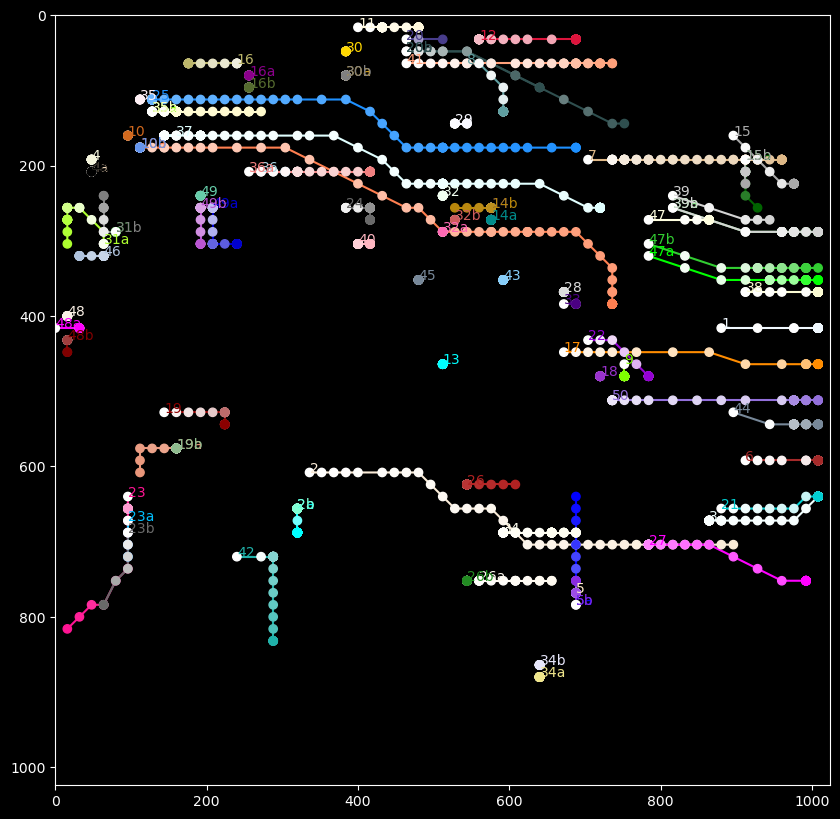

In [86]:
plot_pseudo_track(track_id, all_x_track, all_y_track, start_t, 1024)

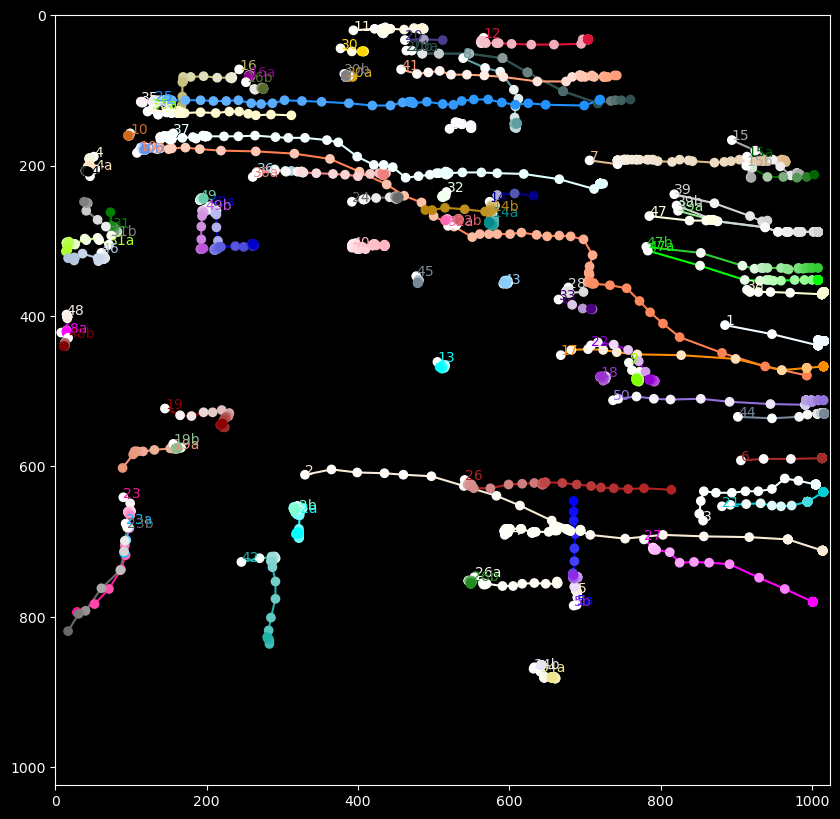

In [99]:
all_x_track_v2, all_y_track_v2 = pseudo_tracking_piv_grid_v2(U, V, start_t, start_x_cor,
                                                            start_y_cor)
plot_pseudo_track(track_id, all_x_track_v2, all_y_track_v2, start_t, 1024)

## Comparison with original track

In [70]:
index=track_id.index("42")

In [78]:
test_x = [[start_x_cor[index][0]]] 
test_y = [[start_y_cor[index][0]]] 
test_t = [start_t[index]]
test_x_track, test_y_track = pseudo_tracking_piv_grid(U, V, test_t, test_x, test_y)

In [79]:
test_t

[array([22, 46], dtype=int64)]

In [80]:
test_x_track

[array([240, 272, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
        288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 272])]

In [81]:
test_y_track

[array([720, 720, 720, 720, 720, 720, 720, 720, 720, 720, 720, 720, 720,
        720, 736, 752, 768, 784, 800, 816, 832, 832, 832, 832, 832])]

In [19]:
track_csv = pandas.read_csv("F:/PhD_Franziska/Headon/Headon_results/v1_slice3/video1_tracking_cleaned.csv")

In [22]:
# Extract certain tracks with given track_ids
def original_track(track_id, track_csv):
    original_x_track = []
    original_y_track = []
    original_t_track = []
    
    for i in track_id:
        o_x = track_csv.loc[track_csv["Track"]==str(i)]["X"].tolist()
        o_y = track_csv.loc[track_csv["Track"]==str(i)]["Y"].tolist()
        o_t = track_csv.loc[track_csv["Track"]==str(i)]["Frame"].tolist()
        original_x_track.append(o_x)
        original_y_track.append(o_y)
        original_t_track.append(o_t)
    return original_x_track, original_y_track, original_t_track

In [87]:
original_track(["42"], track_csv)[0]

[[246,
  244,
  242,
  241,
  241,
  242,
  239,
  237,
  240,
  242,
  242,
  240,
  244,
  246,
  247,
  249,
  249,
  251,
  254,
  251,
  247,
  244,
  247,
  247,
  246]]

In [27]:
U[81][54, 24]

4.0672617

In [28]:
V[81][54, 24]

0.47239113

In [33]:
M[82][54, 24]

4.0946026